# Introducing Snorkel

In this notebook we will use Snorkel to enrich our data such that tags with between 500-2,000 examples will be labeled using weak supervision to produce labels for enough examples to allow us to train an accurate full model that includes these new labels.

More information about Snorkel can be found at [Snorkel.org](https://www.snorkel.org/) :) For a basic introduction to Snorkel, see the [Spam Tutorial](http://syndrome:8888/notebooks/snorkel-tutorials/spam/01_spam_tutorial.ipynb). For an introduction to Multi-Task Learning (MTL), see [Multi-Task Tutorial](http://syndrome:8888/notebooks/snorkel-tutorials/multitask/multitask_tutorial.ipynb).

In [1]:
# Snorkel Introduction

from collections import OrderedDict 
from glob import glob
import os

import pandas as pd
import pyarrow
import random
import snorkel
import tensorflow as tf

random.seed(1337)

In [2]:
TAG_LIMIT = 2000
BAD_LIMIT = 500

In [3]:
PATHS = {
    'final_tag_parquet': {
        'local': '../data/stackoverflow/PerTag.Bad.{}.{}.parquet',
        's3': 's3://stackoverflow-events/PerTag.Bad.{}.{}.parquet',
    }
}

# Define a set of paths for each step for local and S3
PATH_SET = 'local'

In [4]:
%matplotlib inline

# Make sure we're running from the spam/ directory
if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spam")

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# For reproducibility
os.environ["PYTHONHASHSEED"] = "1337"

## Loading our Examples for Enrichment

In [5]:
path = PATHS['final_tag_parquet'][PATH_SET].format(TAG_LIMIT, BAD_LIMIT)

df = pd.read_parquet(
    path, 
    columns=['_Body', '_Index', '_Tag'],
    engine='pyarrow',
)

In [6]:
pd.set_option('display.max_colwidth', 300)
df.head()

,_Body,_Index,_Tag
0,"[Decoding, Base64urlUInt, encoded, value, What, I, generally, trying, validate, id_token, value, obtained, OpenID, Connect, provider, e, g, Google, The, token, signed, RSA, algorithm, public, key, read, Discovery, document, jwks_uri, parameter, For, example, Google, keys, available, JWK, format,...",193,base64
1,"[Python, someone, guess, type, file, base64, encoding, Let, say, I, following, This, dot, image, But, I, know, image, text, etc, Is, possible, understand, encoded, string, I, try, Python, also, general, question, So, insight, highly, welcome, __PAD__, __PAD__, __PAD__, __PAD__, __PAD__, __PAD__,...",193,base64
2,"[String, PublicKey, Header, long, I, trying, create, public, key, string, way, causes, error, Any, solutions, examples, creating, PublicKey, form, String, The, String, 87Avu4YRFh25mG, 5, vW7tFXORD3WYqByKZDHpcqstXKDyLYFtm8arbwXDUxcDRSJUKdZx07L1fGvExfslShssJ22nHA4bScQ7yhgrtsxNUa5NPPP, YlR9DLAnjFzf...",193,base64
3,"[Open, Base64, new, tab, I, Base64, encoded, document, PDF, file, image, I, would, like, create, button, HTML5, page, opens, base64, new, tab, new, page, matter, I, found, code, trick, It, works, well, But, I, replace, http, link, file, downloaded, displayed, browser, How, I, make, Thanks, __PAD...",193,base64
4,"[How, convert, JSON, object, base64, string, I, attempting, follow, Amazon, example, browser, based, file, uploads, S3, using, POST, The, example, provides, JSON, policy, says, base64, encoded, version, policy, However, I, Node, js, REPL, I, get, different, base64, string, Am, I, something, wron...",193,base64


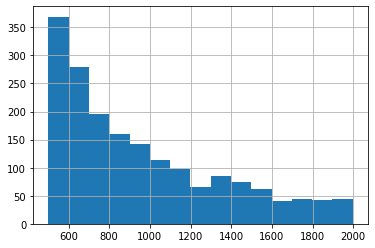

In [7]:
%matplotlib inline

# Make each bin 100 count, since range is atm 500-2,000
df.groupby('_Tag').count()['_Body'].hist(bins=15)

## Sample the Data Initially

In [12]:
SAMPLE_SIZE = 10000


df['_Text'] = df['_Body'].apply(lambda x: ' '.join(x))
df['_Lower_Text'] = df['_Text'].apply(lambda x: x.lower())

# df['_Index_Plus'] = df['_Index'].apply(lambda x: x + 1)

df_sample = df.sample(SAMPLE_SIZE, random_state=1337)

  3%|▎         | 1777/70000 [00:40<19:18, 58.90it/s]

## Split the Data into Train/Test/Development Datasets

We'll need to validate our labeling functions (LFs) in Snorkel, so we need train, test and __development__ datasets.

In [31]:
from sklearn.model_selection import train_test_split


X_train, X_test_dev, y_train, y_test_dev = train_test_split(
    df_sample, 
    df_sample['_Index'], 
    test_size=0.3,
    random_state=1337,
)
X_dev, X_test, y_dev, y_test = train_test_split(
    X_test_dev,
    y_test_dev,
    test_size=0.66667,
    random_state=1337,
)

X_train.shape, X_test.shape, X_dev.shape, y_train.shape, y_test.shape, y_dev.shape

((7000, 6), (2001, 6), (999, 6), (7000,), (2001,), (999,))

## Label Function 1: Contains Tag

The first labeling function we'll create is a keyword search. We'll look for whether the keyword is contained in the dataset. This would be helpful for a question about HTML with the tag `html` where `html` also appears in the body of the post.

### Snorkel Proprocessors and LFs

To do this we'll use a [Snorkel preprocessor](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.preprocessor.html#snorkel.preprocess.preprocessor) that joins and lowercases the text before the LFs act on it.

In [44]:
# Download the spaCy english model
! python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0MB 673kB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-cp37-none-any.whl size=12019125 sha256=13a86e521776048e0004a8ec84320cae4dca9635997cd09f0fd4204d60f6978e
  Stored in directory: /tmp/pip-ephem-wheel-cache-4ntd02p1/wheels/48/5c/1c/15f9d02afc8221a668d2172446dd8467b20cdb9aef80a172a4
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [53]:
from snorkel.preprocess.nlp import SpacyPreprocessor
from snorkel.labeling import LabelingFunction

ABSTAIN = -1


spacy_processor = SpacyPreprocessor(
    text_field='_Lower_Text',
    doc_field='_Doc',
    memoize=True,
)

def keyword_lookup(x, keywords, label):
    if any(word.lower() in x._Doc for word in keywords if len(word) > 2):
        return label
    return ABSTAIN

def make_keyword_lf(keywords, label=ABSTAIN):
    return LabelingFunction(
        name=f"keyword_{keywords}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
        pre=[spacy_processor]
    )


# For each keyword, split on hyphen and create an LF that detects if that tag is present in the data
keyword_lfs = OrderedDict()
for label_set, index in zip(df['_Tag'].unique(), df['_Index'].unique()):
    for label in label_set.split('-'):
        keyword_lfs[label] = make_keyword_lf(label, label=index)

list(keyword_lfs.items())[:5]

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

### Apply our LFs

The

In [56]:
from snorkel.labeling import LFAnalysis, PandasLFApplier


applier = PandasLFApplier(lfs=keyword_lfs.values())

L_train = applier.apply(df=X_train)
L_dev = applier.apply(df=X_dev)

In [54]:
summary = LFAnalysis(L=L_dev, lfs=keyword_lfs.values()).lf_summary(y_dev.as_matrix())
summary

In [55]:
summary.sort_values(by='Correct', ascending=False)